<a href="https://colab.research.google.com/github/abhi01n/MultiLayer-Perceptron-for-MNIST-digit-classfication/blob/main/MultiLayer_Perceptron_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment
Build a 2-layer MLP for MNIST digit classfication. Feel free to play around with the model architecture and see how the training time/performance changes, but to begin, try the following:

Image (784 dimensions) ->
fully connected layer (500 hidden units) -> nonlinearity (ReLU) ->
fully connected (10 hidden units) -> softmax

Try building the model both with basic PyTorch operations, and then again with more object-oriented higher-level APIs. You should get similar results!

Some hints:

Even as we add additional layers, we still only require a single optimizer to learn the parameters. Just make sure to pass all parameters to it!
As you'll calculate in the Short Answer, this MLP model has many more parameters than the logisitic regression example, which makes it more challenging to learn. To get the best performance, you may want to play with the learning rate and increase the number of training epochs.
Be careful using torch.nn.CrossEntropyLoss(). If you look at the PyTorch documentation: you'll see that torch.nn.CrossEntropyLoss() combines the softmax operation with the cross-entropy. This means you need to pass in the logits (predictions pre-softmax) to this loss. Computing the softmax separately and feeding the result into torch.nn.CrossEntropyLoss() will significantly degrade your model's performance!

#Multi-Layer Perceptrons
The simple logistic regression example we went over in the previous notebook is essentially a one-layer neural network, projecting straight from the input to the output predictions. While this can be effective for linearly separable data, occasionally a little more complexity is necessary. Neural networks with additional layers are typically able to learn more complex functions, leading to better performance. These additional layers (called "hidden" layers) transform the input into one or more intermediate representations before making a final prediction.

In the logistic regression example, the way we performed the transformation was with a fully-connected layer, which consisted of a linear transform (matrix multiply plus a bias). A neural network consisting of multiple successive fully-connected layers is commonly called a Multi-Layer Perceptron (MLP). In the simple MLP below, a 4-d input is projected to a 5-d hidden representation, which is then projected to a single output that is used to make the final prediction.
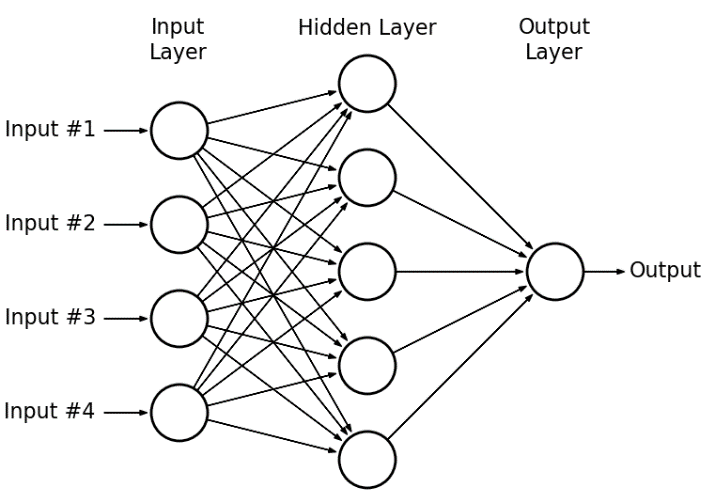

For the assignment, you will be building a MLP for MNIST. Mechanically, this is done very similary to our logistic regression example, but instead of going straight to a 10-d vector representing our output predictions, we might first transform to a 500-d vector with a "hidden" layer, then to the output of dimension 10. Before you do so, however, there's one more important thing to consider.

Nonlinearities
We typically include nonlinearities between layers of a neural network. There's a number of reasons to do so. For one, without anything nonlinear between them, successive linear transforms (fully connected layers) collapse into a single linear transform, which means the model isn't any more expressive than a single layer. On the other hand, intermediate nonlinearities prevent this collapse, allowing neural networks to approximate more complex functions.

There are a number of nonlinearities commonly used in neural networks, but one of the most popular is the rectified linear unit (ReLU):

𝑥=max(0,𝑥)
 
There are a number of ways to implement this in PyTorch. We could do it with elementary PyTorch operations:


In [ ]:
import torch

x = torch.rand(5, 3)*2 - 1
x_relu_max = torch.max(torch.zeros_like(x),x)

print("x: {}".format(x))
print("x after ReLU with max: {}".format(x_relu_max))

x: tensor([[-0.8495,  0.0949,  0.8920],
        [ 0.8239, -0.2340,  0.7531],
        [ 0.4121, -0.3402,  0.8861],
        [-0.5041, -0.9350,  0.0630],
        [-0.8065, -0.1037,  0.0876]])
x after ReLU with max: tensor([[0.0000, 0.0949, 0.8920],
        [0.8239, 0.0000, 0.7531],
        [0.4121, 0.0000, 0.8861],
        [0.0000, 0.0000, 0.0630],
        [0.0000, 0.0000, 0.0876]])


Of course, PyTorch also has the ReLU implemented, for example in **torch.nn.functional**:

In [ ]:
import torch.nn.functional as F

x_relu_F = F.relu(x)

print("x after ReLU with nn.functional: {}".format(x_relu_F))

x after ReLU with nn.functional: tensor([[0.0000, 0.0949, 0.8920],
        [0.8239, 0.0000, 0.7531],
        [0.4121, 0.0000, 0.8861],
        [0.0000, 0.0000, 0.0630],
        [0.0000, 0.0000, 0.0876]])


#Model with basic PyTorch operations

In [ ]:
### YOUR CODE HERE
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torchvision import datasets, transforms

  
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

W = torch.rand(784,500)/np.sqrt(784)
W.requires_grad_()
b = torch.zeros(500, requires_grad=True)

W2 = torch.rand(500,10)/np.sqrt(784)
W2.requires_grad_()
b2 = torch.zeros(10, requires_grad=True)

optimizer = torch.optim.SGD([W,b,W2,b2], lr=0.1)

# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    z = torch.matmul(x, W) + b
    py = F.relu(z)
    y = torch.matmul(py, W2) + b2
    cross_entropy = F.cross_entropy(y, labels)
    # Backward pass
    cross_entropy.backward()
    optimizer.step()

## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        z = torch.matmul(x, W) + b
        py = F.relu(z)
        y = torch.matmul(py, W2) + b2
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))

# Make sure to print out your accuracy on the test set at the end.


Test accuracy: 0.9104999899864197


#Object-oriented higher-level APIs


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(784, 500)
        self.output = nn.Linear(500, 10)
  
    def forward(self, x):
        x = self.hidden(x)
        x = F.sigmoid(x)
        x = self.output(x)
        return x

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Instantiate model
model = Model()

# Loss and Optimizer

criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(model.parameters(), lr=0.1)


# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer1.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    z = model(x)
    loss = criterion(z, labels)
    # Backward pass
    loss.backward()
    optimizer1.step()

## Testing
correct_api = 0
total_api = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        z = model(x)
        predictions_api = torch.argmax(z, dim=1)
        correct_api += torch.sum((predictions_api == labels).float())
    
print('Test accuracy: {}'.format(correct_api/total_api))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Test accuracy: 0.8614000082015991


#The number of trainable parameter 

I​mage (784 dimensions) ->
fully connected layer (500 hidden units) -> nonlinearity (ReLU) ->
fully connected (10 hidden units) -> softmax
W​hich suggests:

B​ase layer (784) -> hidden1 (500) -> ReLU -> Output (10)
T​herefore: (784* 500)+500, (10*500)+10



In [1]:
Trainable_parameter = (784*500)+500 + (10*500)+10
Trainable_parameter

397510

If Don't get then follow my **Introduction to Logistic Regression in PyTorch** link is below:
 
https://github.com/abhi01n/Introduction-to-Logistic-Regression-in-PyTorch-MNIST-Dataset-